In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import joblib

pt_pos_tagger = joblib.load('/content/drive/MyDrive/PTvsBR/POS_tagger_brill.pkl')

import warnings
warnings.filterwarnings('ignore')

In [26]:
dir = "1k-sent"
prefix = "tedtalks-1k-sent-dev"
dataset = pd.read_csv(f'/content/drive/MyDrive/PTvsBR/data/{dir}/{prefix}-raw.csv', sep=';')
dataset = dataset.dropna()
dataset = dataset.reset_index(drop=True)
dataset['label_bool'] = dataset['label'].map({'PT': 1, 'BR': 0})

### Length Based Filtering

Text(0, 0.5, 'Number of entries')

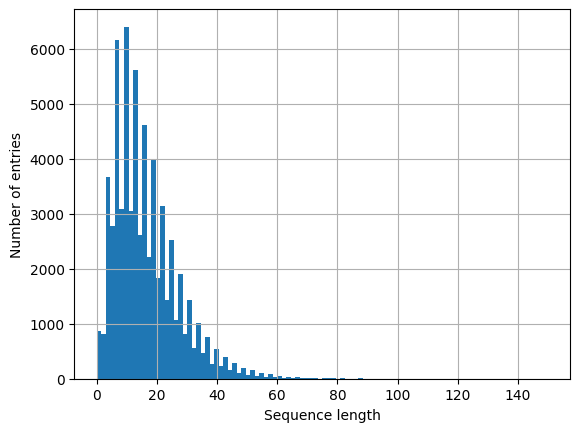

In [27]:
# get length of all the messages in the train set
dataset["seq_len"] = dataset["text"].apply(lambda x: len(x.split()))
# histogram of sequence length, adjust range to better visualize
axes = dataset["seq_len"].hist(bins=100, range=[0, 150])
axes.set_xlabel("Sequence length")
axes.set_ylabel("Number of entries")

In [28]:
# remove all samples with length less than 10 words
dataset = dataset[dataset["seq_len"] >= 10]
dataset.reset_index(inplace=True, drop=True)
print("Number of samples:", len(dataset))
print("Number of PT samples:", len(dataset[dataset["label"] == "PT"]))
print("Number of BR samples:", len(dataset[dataset["label"] == "BR"]))

Number of samples: 45030
Number of PT samples: 22407
Number of BR samples: 22623


<Axes: >

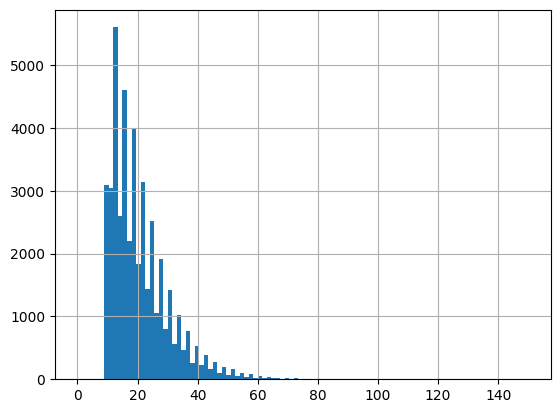

In [29]:
dataset["seq_len"].hist(bins=100, range=[0, 150])

### Quality Based Filtering

In [19]:
# remove all samples with special |, #, _, ;, :, $, @, &, /, \, 'Clique', 'cookie', 'clique', 'Cookie'
dataset = dataset[~dataset["text"].str.contains("\|")]
dataset = dataset[~dataset["text"].str.contains("#")]
dataset = dataset[~dataset["text"].str.contains("_")]
#dataset = dataset[~dataset["text"].str.contains(";")]
#dataset = dataset[~dataset["text"].str.contains(":")]
dataset = dataset[~dataset["text"].str.contains("\$")]
dataset = dataset[~dataset["text"].str.contains("@")]
dataset = dataset[~dataset["text"].str.contains("&")]
dataset = dataset[~dataset["text"].str.contains("/")]
dataset = dataset[~dataset["text"].str.contains("\\\\")]
dataset = dataset[~dataset["text"].str.contains("Clique")]
dataset = dataset[~dataset["text"].str.contains("cookie")]
dataset = dataset[~dataset["text"].str.contains("clique")]
dataset = dataset[~dataset["text"].str.contains("Cookie")]
dataset.reset_index(inplace=True, drop=True)
print("Number of samples:", len(dataset))
print("Number of PT samples:", len(dataset[dataset["label"] == "PT"]))
print("Number of BR samples:", len(dataset[dataset["label"] == "BR"]))

Number of samples: 44764
Number of PT samples: 22331
Number of BR samples: 22433


In [20]:
# remove any entry with the same text for both languages
dataset = dataset.drop_duplicates(subset=['text'], keep=False)
print("Number of samples:", len(dataset))
print("Number of PT samples:", len(dataset[dataset["label"] == "PT"]))
print("Number of BR samples:", len(dataset[dataset["label"] == "BR"]))

Number of samples: 170478
Number of PT samples: 84719
Number of BR samples: 85759


### Features

In [21]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [23]:
import features
dataset = features.get_features(dataset)

In [24]:
print("Features correlation with label:")
print()

print(dataset.corr(numeric_only=True)["label_bool"].sort_values(ascending=False)[1:])

Features correlation with label:

pt_pt_pronoun_position_hints_bool               0.190695
pt_pt_pronoun_position_hints                    0.185326
a_plus_infinitive_count_bool                    0.174068
a_plus_infinitive_count                         0.171200
count_article_before_possessive_pronoun_bool    0.125260
count_article_before_possessive_pronoun         0.122052
count_portuguese_words                          0.059681
pt_pt_second_person_hints_bool                  0.039159
pt_pt_second_person_hints                       0.038112
count_acute_accent                              0.018270
seq_len                                        -0.003368
count_uncontracted_words                       -0.016414
count_uncontracted_words_bool                  -0.016488
count_brazilian_words                          -0.043182
count_circumflex_accent                        -0.148199
pt_br_pronoun_position_hints_bool              -0.163632
pt_br_second_person_hints                      -0.1696

In [25]:
dataset.to_csv(f'/content/drive/MyDrive/PTvsBR/data/{dir}/{prefix}-features.csv', index=False)

In [ ]:
# print examples with count_uncontracted_words > 0
print("Examples with count_uncontracted_words > 0:")
print()
print(dataset[dataset["count_uncontracted_words"] > 0][["text", "count_uncontracted_words", "label"]].head(2))
print(dataset["text"][4])
print(features.tag_sentence(dataset["text"][4]))

Examples with count_uncontracted_words > 0:

                                                 text   
43  Captura e sequestro de carbono -- é o que CCS ...  \
60  Trabalhar com Larry Lessig, isso virá em algum...   

    count_uncontracted_words label  
43                         1    BR  
60                         1    BR  
(risadas e aplausos) Eu vou contar uma rápida história para mostrar o que isso significa para mim.
[('(', '('), ('risadas', 'N'), ('e', 'KC'), ('aplausos', 'N'), (')', ')'), ('eu', 'PROPESS'), ('vou', 'VAUX'), ('contar', 'V'), ('uma', 'ART'), ('rápida', 'ADJ'), ('história', 'N'), ('para', 'PREP'), ('mostrar', 'V'), ('o', 'PRO-KS'), ('que', 'PRO-KS'), ('isso', 'PROSUB'), ('significa', 'V'), ('para', 'PREP'), ('mim', 'PROPESS'), ('.', '.')]
